<a href="https://colab.research.google.com/github/lovellbrian/ELEC4630/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ELEC4630
Neural Style Transfer

In [0]:
# First store some sample images in the folder 'images' and create results 'folder'
!mkdir -p images
!mkdir -p results
!cd images; wget -nc https://raw.githubusercontent.com/lovellbrian/ELEC4630/master/Images/tuebingen.jpg
!cd images; wget -nc https://raw.githubusercontent.com/lovellbrian/ELEC4630/master/Images/starry_night.jpg

#Neural style transfer with Keras.

<!-- Run the script with:
```
python neural_style_transfer.py path_to_your_base_image.jpg \
    path_to_your_reference.jpg prefix_for_results
```
e.g.:
```
python neural_style_transfer.py img/tuebingen.jpg \
    img/starry_night.jpg results/my_result
```
Optional parameters:
```
--iter, To specify the number of iterations \
    the style transfer takes place (Default is 10)
--content_weight, The weight given to the content loss (Default is 0.025)
--style_weight, The weight given to the style loss (Default is 1.0)
--tv_weight, The weight given to the total variation loss (Default is 1.0)
``` -->

It is preferable to run this script on GPU, for speed.

Example result: https://twitter.com/fchollet/status/686631033085677568

# Details

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).

This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.

- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).

 - The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

# References
[A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576)

Run in tensorflow V1 compatibility mode

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


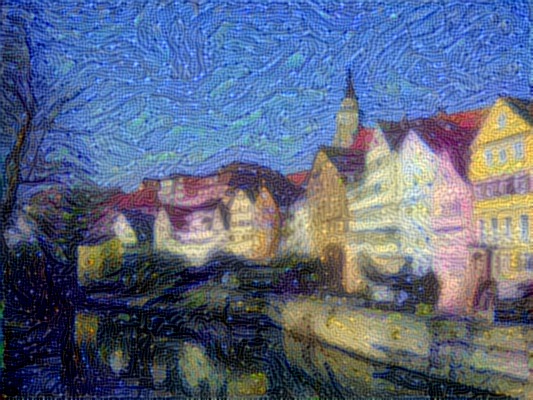

Image saved as results/my_art_at_iteration_9.png
Iteration 9 completed in 4s



In [23]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K

# parser = argparse.ArgumentParser(description='Neural style transfer with Keras.')
# parser.add_argument('base_image_path', metavar='base', type=str,
#                     help='Path to the image to transform.')
# parser.add_argument('style_reference_image_path', metavar='ref', type=str,
#                     help='Path to the style reference image.')
# parser.add_argument('result_prefix', metavar='res_prefix', type=str,
#                     help='Prefix for the saved results.')
# parser.add_argument('--iter', type=int, default=10, required=False,
#                     help='Number of iterations to run.')
# parser.add_argument('--content_weight', type=float, default=0.025, required=False,
#                     help='Content weight.')
# parser.add_argument('--style_weight', type=float, default=1.0, required=False,
#                     help='Style weight.')
# parser.add_argument('--tv_weight', type=float, default=1.0, required=False,
#                     help='Total Variation weight.')

# args = parser.parse_args()
# base_image_path = args.base_image_path
# style_reference_image_path = args.style_reference_image_path
# result_prefix = args.result_prefix
# iterations = args.iter

# args = parser.parse_args()
base_image_path = "images/tuebingen.jpg"
style_reference_image_path = "images/starry_night.jpg"
result_prefix = "results/my_art"
iterations = 10

# these are the weights of the different loss components
# total_variation_weight = args.tv_weight
# style_weight = args.style_weight
# content_weight = args.content_weight

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# util function to open, resize and format pictures into appropriate tensors


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] = x[:, :, 0] + 103.939   # += is deprecated
    x[:, :, 1] = x[:, :, 1] + 116.779
    x[:, :, 2] = x[:, :, 2] + 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs = outputs + grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

x = preprocess_image(base_image_path)
img = deprocess_image(x.copy())
img_pil = array_to_img(img)
# show original image
display(img_pil)
print("Original Image\n")

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    img_pil = array_to_img(img)
    display(img_pil)
    fname = result_prefix + '_at_iteration_%d.png' %i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    print()

